In [1]:
# 读取数据
import json
with open('output/quantangshi.json',encoding='utf-8') as f:
    qtsdata = json.load(f)
print(qtsdata[0])

{'author': '太宗皇帝', 'paragraphs': ['秦川雄帝宅，函谷壯皇居。', '綺殿千尋起，離宮百雉餘。', '連甍遙接漢，飛觀迥凌虛。', '雲日隱層闕，風煙出綺疎。'], 'title': '帝京篇十首 一', 'id': '3ad6d468-7ff1-4a7b-8b24-a27d70d00ed4', 'tokenparas': ['秦 川 雄 帝 宅 ， 函 谷 壯 皇 居 。', '綺 殿 千 尋 起 ， 離 宮 百 雉 餘 。', '連 甍 遙 接 漢 ， 飛 觀 迥 凌 虛 。', '雲 日 隱 層 闕 ， 風 煙 出 綺 疎 。']}


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 設置本地字體文件路徑
font_path = r'C:\Windows\Fonts\simkai.ttf'

# 使用FontProperties類來設置字體
custom_font = mpl.font_manager.FontProperties(fname=font_path)

# 設置Matplotlib的rcParams
plt.rcParams['font.sans-serif'] = custom_font.get_name()
mpl.rcParams['font.sans-serif'] = custom_font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 防止坐标轴负号显示异常

In [3]:
# 查询包含某一个重言词的位置，输出总句数，标题和作者
def lookup_lines(word):
    lines = []
    for poem in qtsdata:
        title = poem['title']
        author = poem['author']
        for line in poem['paragraphs']:
            if word in line:
                lines.append(f'{line}——《{title}》{author}')
                
    print(f'{word}共{len(lines)}句。如下')
    for line in lines:
        print(line)
# word = '赫赫'
# lookup_lines(word)

In [4]:
# 查询包含多个词语的句子，输出句子、标题和作者
def lookup_lines_list(wordli,is_print = 1):
    lines = []
    for poem in qtsdata:
        title = poem['title']
        author = poem['author']
        for tokenpara in poem['tokenparas']:
            tokens = tokenpara.split()
            jiaoji = set(tokens) & set(wordli)
            if len(jiaoji) == len(wordli):
                line = tokenpara.replace(" ","")
                lines.append(f'{line}——《{title}》{author}')
    if is_print == 1:            
        print(f'{" ".join(wordli)}共{len(lines)}句。如下')
        for line in lines:
            print(line)
    return lines

# wordli = ['皇','居']
# lookup_lines_list(wordli)

In [5]:
# 共现词频统计的基础工作
with open('output/quantangshi_token.txt','r',encoding= 'utf-8') as f:
    qtsli =[x.replace('\n',"") for x in f.readlines()] 
# print(qtsli[:10])
tokenized_corpus = [x.split() for x in qtsli]

import pickle,json,time
with open('output/chongyanlist.pkl', 'rb') as file:
    cy_set = list(pickle.load(file))

# 统计每一个词的共现词有哪些，以列表存储
from collections import defaultdict
cy_linedict = defaultdict(list)

for cyword in cy_set:
    for line in tokenized_corpus:
        if cyword in line:
            cy_linedict[cyword] = cy_linedict[cyword] + line
            
# 统计每个重言词的共现词的频次
from collections import Counter
cy_counter = {}
for cyword,cywordlines in cy_linedict.items():
    element_count = Counter(cywordlines)
    cy_counter[cyword] = element_count
# print(cy_counter['連連'])


In [27]:
# 生成共现词词云图
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

def wordcloud(word,to_pic = 0):
    counter = cy_counter[word]
    for i in ['，','。','！','？']:
        if i in counter.keys():
            del counter[i]
        
    font_path = r'C:\Windows\Fonts\simkai.ttf'
    # 自定义颜色函数
    def custom_color_func(word, font_size, position, orientation, random_state, **kwargs):
        color_list = ['#3b6291', '#943c39', '#779043', '#624c7c','#388498', '#bf7334', '#3f6899', '#9c403d', '#7d9847', '#675083', '#3b8ba1', '#c97937']
        random_color = random.choice(color_list)
    
        return random_color  # 自定义16进制颜色码
    
    
    # 创建词云对象
    wordcloud = WordCloud(width=800, height=800,font_path=font_path, background_color='white',color_func=custom_color_func).generate_from_frequencies(counter)
    
    # 绘制词云
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # 关闭坐标轴
    plt.show()
    if to_pic == 1:
        wordcloud.to_file(f"output/{word}.png")
    print(counter)
    # return counter
# counter = wordcloud('皇皇')
# print(counter)

In [7]:
# 输入一个列表，生成这个列表所包含词语的位置分布图
import numpy as np
def li_position(wordli):
   # 初始化一个100维的向量，用于记录词语位置分布
    position_vector = np.zeros(100)
    for cy_word in wordli:
        word_lines = []
        for line in qtsli:
            if cy_word in line:
                line = line.replace(' ','')
                word_lines.append(line)
        # print(len(word_lines),word_lines[:10])
        
        # 遍历句子，记录词语位置分布
        for sentence in word_lines:
            if cy_word in sentence:
                start_position = sentence.index(cy_word)
                end_position = start_position + len(cy_word)
                start_percent = start_position / len(sentence) * 100
                end_percent = end_position / len(sentence) * 100
                position_vector[int(start_percent):int(end_percent)] += 1
            
    
    # 使用Matplotlib绘制热力图
    plt.figure(figsize=(15, 2))
    plt.imshow(position_vector.reshape(1, -1), cmap="YlGnBu", aspect="auto")
    plt.colorbar(label="词语出现次数")
    plt.xlabel("位置百分比")
    plt.title(f"{' '.join(wordli)}位置分布")
    plt.xticks(range(0, 100, 10), [f"{i}%" for i in range(0, 100, 10)])
    plt.yticks([])  # 隐藏Y轴
    plt.show()
   
# li_position(['蒼蒼'])

In [8]:
# 输入一个列表，输出列表词语的共同共现词的桑基图，并且打开这个页面
from pyecharts import options as opts
from pyecharts.charts import Sankey
import webbrowser,os
def sanjilist(wordli):
    countsli = [cy_counter[x] for x in wordli]
    countsumli = [sum(countsli[wordli.index(x)].values()) for x in wordli]
    
    # 找每两个词的共同共现词组合成一个交集
    intersation = set()
    for i in wordli:
        for j in wordli:
            if i == j:
                continue
            keys1 = countsli[wordli.index(i)].keys()
            keys2 = countsli[wordli.index(j)].keys()
            aintersation = set(keys1) & set(keys2)
            intersation = aintersation | intersation 
    print(intersation)
    
    # 找个词在所有词出现的总次数，如果低于某个阈值就不出现，形成一个交集
    intersation_gap = len(wordli)
    intersation2 = []
    bingji = []
    for i in wordli:
        gongxianwords = countsli[wordli.index(i)].keys()
        bingji += gongxianwords
    # print(bingji)
    bingjicount = [0] * len(bingji)
    for i in wordli:
        for ind,j in enumerate(bingji):
            bingjicount[ind] += countsli[wordli.index(i)][j]
    # print(bingjicount)
    for i in range(len(bingji)):
        gongxianword = bingji[i]
        if gongxianword in  ['，','。','！','？']:
            continue
        if bingjicount[i] <= intersation_gap:
            continue
        intersation2.append(gongxianword)
    print(intersation2)
    
    # 找同时满足两个条件的共现词
    intersation = list(intersation & set(intersation2))
    print(intersation)
    
    for i in wordli:
        if i not in intersation:
            intersation.append(i)
        
    # 生成节点和边
    nodes = []
    for label in intersation:
        nodes.append({'name':label})   
    
    links = []
    for ind,word in enumerate(wordli):
        for gongxianword in intersation:
            if gongxianword in wordli:
                if wordli.index(gongxianword) <= ind:
                    continue
            conuts = countsli[wordli.index(word)]
            value = conuts[gongxianword]
            lines = lookup_lines_list([word,gongxianword],is_print = 0)
            tooltip = "{}-{}({}):<br/>{}".format(word,gongxianword,len(lines),'<br/>'.join(lines))
            if value != 0:
                links.append({'source':word,'target':gongxianword,'value':value, 'tooltip':tooltip })
            
            
            
    # print(links[-1])
    
    # 生成桑基图
    sankey = (
        Sankey()
        .add(
            "",
            nodes,
            links,
            orient ="vertical",
            node_gap = 5,
            linestyle_opt=opts.LineStyleOpts(opacity=0.3, curve=0.5, color="source",type_="dotted"),
            label_opts=opts.LabelOpts(position="top",),
        )
        .set_global_opts(title_opts=opts.TitleOpts(title=f"{' '.join(wordli)}共同共现词"),)
    )
    # 保存图表为 HTML 文件
    filename = f"output/{' '.join(wordli)}共现词.html"
    sankey.render(filename)  
    path = os.path.abspath(filename)
    url = 'file://' + path
    webbrowser.open(url)

    
# wordli = ['粲粲', '皇皇' ]
# sanjilist(wordli)

# 调用

皇皇共31句。如下
皇皇靈睠，穆穆神心。——《唐大饗拜洛樂章 通和》則天皇后
肅振振，鏗皇皇。——《郊廟歌辭 封泰山樂章 豫和 三》張說
皇皇后祖，來我思成。——《郊廟歌辭 封泰山樂章 雍和》張說
皇皇降嘏，天子萬年。——《郊廟歌辭 封泰山樂章 壽和》張說
天回雲粹，穆穆皇皇。——《郊廟歌辭 祀九宮貴神樂章 太和》不詳
皇皇靈睠，穆穆神心。——《郊廟歌辭 武后大享拜洛樂章 通和》不詳
赫赫玄功被穹壤，皇皇至德洽生靈。——《郊廟歌辭 武后享清廟樂章十首 第七迎武舞》不詳
皇皇后祖，來我思成。——《郊廟歌辭 享太廟樂章 雍和二章 二》張說
歌纍纍，容皇皇。——《郊廟歌辭 周宗廟樂舞辭 善慶舞》不詳
君臣已定兮君永無疆，顏子更生兮徒皇皇。——《中和樂九章 總歌第九》盧照鄰
肅振振，鏗皇皇。——《唐封泰山樂章 豫和六首 三》張說
皇皇我祖，來我思成。——《唐封泰山樂章 雍和》張說
皇皇降嘏，天子萬年。——《唐封泰山樂章 壽和》張說
皇皇后祖，來我思成。——《唐享太廟樂章 雍和二首 二》張說
皇皇軒轅君，贊贊臯陶謨。——《觀范陽遞俘》儲光羲
看君發原隰，駟牡志皇皇。——《送邵州判官往南》劉長卿
皇皇三十載，書劒兩無成。——《自洛之越》孟浩然
肅肅領舊藩，皇皇降璽書。——《送虞城劉明府謁魏郡苗太守》高適
皇皇使臣體，信是德業優。——《毒熱寄簡崔評事十六弟》杜甫
看君發原隰，四牡去皇皇。——《送鄒判官赴河南》皇甫冉
東土苗人尚有殘，皇皇亞相出朝端。——《書情上李蘇州》嚴維
皇皇紫微君，左右皆靈娥。——《朝上清歌》顧況
解送刻毛寄新兔，三皇皇后七貴人。——《榮華樂》李賀
二子未及伸拜謝，蒼蒼上兮皇皇下。——《會仙歌》鮑溶
楚客秋更悲，皇皇無聲地。——《秋思》鮑溶
皇皇大舜，合堯玄德。——《大蜀皇帝壽春節進堯銘舜頌二首 舜頌》貫休
皇皇三川守，馨德清明躬。——《府尹王侍郎准制拜嶽因狀嵩高靈勝寄呈三十韻》尉遲汾
皇皇平原守，駟馬出關東。——《奉寄平原顏太守（幷序）》高適
生受刀光苦，意裏極皇皇。——《五言詩 二》缺名
聖母皇皇，撫臨四方。——《載初元年沙州歌謠（幷序○題擬。以下歌）》佚名
皇皇聖母，定縱服橫。——《載初元年沙州歌謠（幷序○題擬。以下歌）》佚名


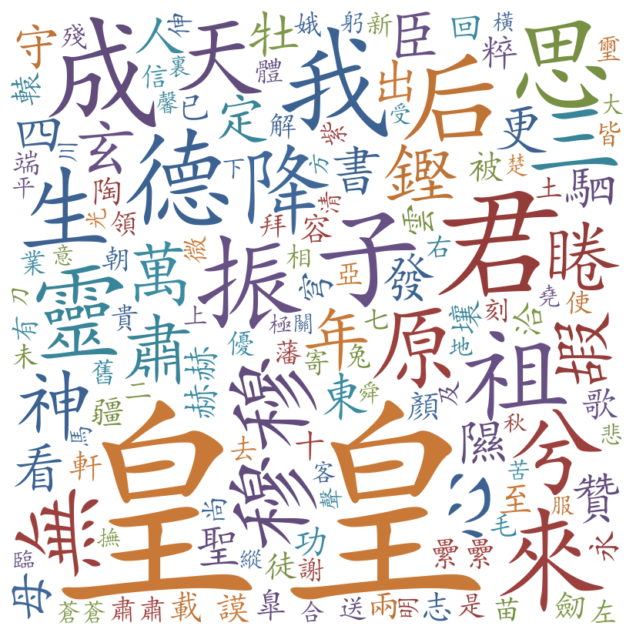

Counter({'皇皇': 31, '君': 6, '我': 5, '成': 5, '靈': 4, '振': 4, '后': 4, '祖': 4, '來': 4, '思': 4, '子': 4, '德': 4, '穆穆': 3, '降': 3, '天': 3, '生': 3, '兮': 3, '無': 3, '原': 3, '三': 3, '睠': 2, '神': 2, '心': 2, '肅': 2, '鏗': 2, '嘏': 2, '萬': 2, '年': 2, '玄': 2, '臣': 2, '定': 2, '更': 2, '贊': 2, '看': 2, '發': 2, '隰': 2, '駟': 2, '牡': 2, '書': 2, '四': 2, '東': 2, '人': 2, '出': 2, '守': 2, '聖': 2, '母': 2, '回': 1, '雲': 1, '粹': 1, '赫赫': 1, '功': 1, '被': 1, '穹': 1, '壤': 1, '至': 1, '洽': 1, '歌': 1, '纍纍': 1, '容': 1, '已': 1, '永': 1, '疆': 1, '顏': 1, '徒': 1, '軒': 1, '轅': 1, '臯': 1, '陶': 1, '謨': 1, '志': 1, '十': 1, '載': 1, '劒': 1, '兩': 1, '肅肅': 1, '領': 1, '舊': 1, '藩': 1, '璽': 1, '使': 1, '體': 1, '信': 1, '是': 1, '業': 1, '優': 1, '去': 1, '土': 1, '苗': 1, '尚': 1, '有': 1, '殘': 1, '亞': 1, '相': 1, '朝': 1, '端': 1, '紫': 1, '微': 1, '左': 1, '右': 1, '皆': 1, '娥': 1, '解': 1, '送': 1, '刻': 1, '毛': 1, '寄': 1, '新': 1, '兔': 1, '七': 1, '貴': 1, '二': 1, '未': 1, '及': 1, '伸': 1, '拜': 1, '謝': 1, '蒼蒼': 1, '上': 1, '下': 1, '楚': 1, '客': 1, '秋': 1, '悲': 1, 

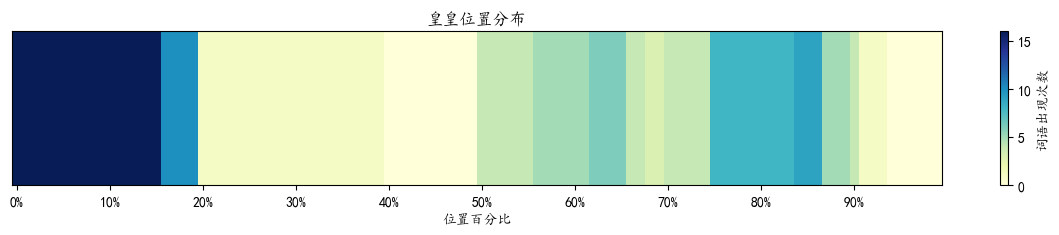

{'雍雍', '方', '青', '莫', '金', '其', '之', '亦', '穆穆', '鳳', '潔', '玄', '恢', '執', '祠', '羣', '聖', '茲', '深', '鸞', '森森', '皇皇', '苑', '典', '臨', '網', '靈', '人', '夜', '愔愔', '盛', '帝', '堂', '疎', '濟濟', '我', '嚴', '義', '洪', '天', '。', '煌煌', '水', '儀', '開', '有', '沙', '孝', '歸', '規', '自', '賢', '丹', '既', '裸', '九', '宗', '中', '容', '道', '晚', '飛', '皇', '書', '師', '唐', '樹', '奠', '生', '軒', '玉', '氣', '登', '戒', '來', '神', '戎', '相', '旌', '龍', '雲', '享', '廟', '何', '明明', '風', '年', '奕奕', '先', '門', '元', '肅肅', '心', '朝', '德', '，', '子', '花', '饗', '國', '高', '居', '清', '揚', '守', '陰', '鏘鏘', '宸', '鹿', '鬯', '餘', '親', '爲', '明', '上', '乾', '列', '下', '兮', '赫赫', '重', '巍巍', '成'}
['乾', '翼翼', '鏘鏘', '容', '兮', '煌煌', '自', '皇', '之', '肅肅', '雍雍', '神', '其', '來', '典', '清', '廟', '有', '盛', '靈', '德', '穆穆', '聖', '皇', '明', '天', '相', '門', '門', '肅肅', '清', '靈', '煌煌', '祀', '典', '邕', '禮', '明', '雍雍', '神', '其', '來', '廟', '盛', '祖', '方', '德', '風', '雲', '金', '容', '既', '列', '兮', '不', '生', '自', '鏘鏘', '天', '有', '帝', '羣', '子', '上', '相', '上', '帝', '穆穆', '靈', '神', '其', '天',

In [31]:
# 调用示例
word = '皇皇'
lookup_lines(word)

# wordli = ['皇','居']
# lookup_lines_list(wordli)

wordcloud(word)

li_position([word])

# wordli = ['粲粲', '皇皇' ,'赫赫', '翼翼', '雍雍' ,'洋洋' ,'肅肅' ,'穆穆', '奕奕' ,'昭昭' ,'煌煌','濟濟','穰穰']
wordli = ['粲粲','赫赫','昭昭','煌煌']
wordli = ['皇皇','洋洋','奕奕','濟濟','穰穰']
wordli = ['翼翼','雍雍','肅肅','穆穆']
sanjilist(wordli)

In [22]:
lookup_lines_list(['禮','樂'])

禮 樂共177句。如下
兩司謬忝謝鍾裴，禮樂銓管效涓埃。——《十月誕辰內殿宴羣臣效柏梁體聯句》中宗皇帝
陰陽調曆象，禮樂報玄穹。——《春晚宴兩相及禮官麗正殿學士探得風字》明皇帝
禮中推意厚，樂處感心微。——《首夏花萼樓觀羣臣宴寧王山亭回樓下又申之以賞樂賦詩》明皇帝
禮樂沿今古，文章革舊新。——《集賢書院成送張說上集賢學士賜宴得珍字》明皇帝
禮樂中朝貴，神明列郡欽。——《賜崔日知往潞州》明皇帝
不戰要荒服，無刑禮樂新。——《春中興慶宮酺宴》明皇帝
禮崇備物，樂奏鏘金。——《唐享昊天樂 第六》則天皇后
禮終肆類，樂闋九成。——《唐享昊天樂 第十一》則天皇后
衣冠陪御宴，禮樂盛朝宗。——《奉和御製麟德殿宴百僚應制》尚宮宋氏若昭
禮惟崇德，樂以和聲。——《郊廟歌辭 祀圜丘樂章 太和》褚亮
禮崇備物，樂奏鏘金。——《郊廟歌辭 武后大享昊天樂章 六》不詳
禮終肆類，樂闋九成。——《郊廟歌辭 武后大享昊天樂章 十一》不詳
郊壇齋帝，禮樂祀天。——《郊廟歌辭 明皇祀圜丘樂章 太和》不詳
禮樂具舉，濟濟洋洋。——《郊廟歌辭 封泰山樂章 太和》張說
大樂稀音，至誠簡禮。——《郊廟歌辭 五郊樂章 青帝角音 雍和》魏徵
禮陳牲幣，樂備篪簧。——《郊廟歌辭 五郊樂章 赤帝徵音 雍和》魏徵
禮和樂備，神其降斯。——《郊廟歌辭 朝日樂章 迎神》不詳
樂終廣奏，禮畢崇禋。——《郊廟歌辭 朝日樂章 送神》不詳
禮陳瑤幣，樂獻金奏。——《郊廟歌辭 祀風師樂章 奠幣登歌》包佶
樂備金石，禮光尊俎。——《郊廟歌辭 祭方丘樂章 順和》不詳
樂和禮備，候暖風春。——《郊廟歌辭 祭汾陰樂章 姑洗徵》劉晃
禮樂備矣，降福穰穰。——《郊廟歌辭 祭汾陰樂章 太和》王晙
禮物斯具，樂章乃陳。——《郊廟歌辭 祭汾陰樂章 壽和》蘇頲
樂奏云闋，禮章載虔。——《郊廟歌辭 祭汾陰樂章 舒和》何鸞
大禮已備，大樂斯張。——《郊廟歌辭 祭汾陰樂章 凱安》蔣挺
樂盈而反，禮順其禋。——《郊廟歌辭 禪社首樂章 壽和》賀知章、源乾曜
樂以平志，禮以和容。——《郊廟歌辭 禪社首樂章 福和》賀知章、源乾曜
禮以導神，樂以和性。——《郊廟歌辭 祭神州樂章 雍和》褚亮
盛禮畢陳，嘉樂備舉。——《郊廟歌辭 享先農樂章 雍和》褚亮
禮備其容，樂和其變。——《郊廟歌辭 釋奠文宣王樂章 雍和》不詳
樂以感靈，禮以昭事。——《郊廟歌辭 享太廟樂章 雍和》

['兩司謬忝謝鍾裴，禮樂銓管效涓埃。——《十月誕辰內殿宴羣臣效柏梁體聯句》中宗皇帝',
 '陰陽調曆象，禮樂報玄穹。——《春晚宴兩相及禮官麗正殿學士探得風字》明皇帝',
 '禮中推意厚，樂處感心微。——《首夏花萼樓觀羣臣宴寧王山亭回樓下又申之以賞樂賦詩》明皇帝',
 '禮樂沿今古，文章革舊新。——《集賢書院成送張說上集賢學士賜宴得珍字》明皇帝',
 '禮樂中朝貴，神明列郡欽。——《賜崔日知往潞州》明皇帝',
 '不戰要荒服，無刑禮樂新。——《春中興慶宮酺宴》明皇帝',
 '禮崇備物，樂奏鏘金。——《唐享昊天樂 第六》則天皇后',
 '禮終肆類，樂闋九成。——《唐享昊天樂 第十一》則天皇后',
 '衣冠陪御宴，禮樂盛朝宗。——《奉和御製麟德殿宴百僚應制》尚宮宋氏若昭',
 '禮惟崇德，樂以和聲。——《郊廟歌辭 祀圜丘樂章 太和》褚亮',
 '禮崇備物，樂奏鏘金。——《郊廟歌辭 武后大享昊天樂章 六》不詳',
 '禮終肆類，樂闋九成。——《郊廟歌辭 武后大享昊天樂章 十一》不詳',
 '郊壇齋帝，禮樂祀天。——《郊廟歌辭 明皇祀圜丘樂章 太和》不詳',
 '禮樂具舉，濟濟洋洋。——《郊廟歌辭 封泰山樂章 太和》張說',
 '大樂稀音，至誠簡禮。——《郊廟歌辭 五郊樂章 青帝角音 雍和》魏徵',
 '禮陳牲幣，樂備篪簧。——《郊廟歌辭 五郊樂章 赤帝徵音 雍和》魏徵',
 '禮和樂備，神其降斯。——《郊廟歌辭 朝日樂章 迎神》不詳',
 '樂終廣奏，禮畢崇禋。——《郊廟歌辭 朝日樂章 送神》不詳',
 '禮陳瑤幣，樂獻金奏。——《郊廟歌辭 祀風師樂章 奠幣登歌》包佶',
 '樂備金石，禮光尊俎。——《郊廟歌辭 祭方丘樂章 順和》不詳',
 '樂和禮備，候暖風春。——《郊廟歌辭 祭汾陰樂章 姑洗徵》劉晃',
 '禮樂備矣，降福穰穰。——《郊廟歌辭 祭汾陰樂章 太和》王晙',
 '禮物斯具，樂章乃陳。——《郊廟歌辭 祭汾陰樂章 壽和》蘇頲',
 '樂奏云闋，禮章載虔。——《郊廟歌辭 祭汾陰樂章 舒和》何鸞',
 '大禮已備，大樂斯張。——《郊廟歌辭 祭汾陰樂章 凱安》蔣挺',
 '樂盈而反，禮順其禋。——《郊廟歌辭 禪社首樂章 壽和》賀知章、源乾曜',
 '樂以平志，禮以和容。——《郊廟歌辭 禪社首樂章 福和》賀知章、源乾曜',
 '禮以導神，樂以和性。——《郊廟歌辭 祭神州

In [76]:
# wordli = ['粲粲', '皇皇' ,'赫赫', '翼翼', '雍雍' ,'洋洋' ,'肅肅' ,'穆穆', '炎炎', '奕奕' ,'馥馥' ,'昭昭' ,'煌煌','濟濟','穰穰','亹亹']
# 
# sanjilist(wordli)

{'貴', '內', '印', '國', '望', '大', '衣', '代', '靈', '振', '浮', '衛', '享', '會', '兮', '萸', '于', '聲', '宸', '星', '積', '英', '三', '齊', '邕', '澤', '目', '臨', '飛', '揚', '齋', '履', '闢', '輝輝', '光', '去', '春', '昔', '直', '蠅', '烈', '干', '名', '義', '姿', '旗', '寂寂', '在', '容', '求', '金', '闈', '玉', '洽', '還', '稟', '情', '太', '祠', '久', '時', '秋', '辰', '垂', '回', '紅', '駸駸', '是', '樂', '鐘', '撫', '月', '景', '今', '戎', '帝', '外', '故', '朝', '雪', '闔', '丹', '全', '陰', '人', '命', '心', '酒', '對', '理', '洪', '自', '鳴', '吉', '營', '凝', '北', '翹', '賢', '旌', '耀', '離', '衆', '燭', '疑', '具', '方', '摶', '濟濟', '定', '多', '皆', '騎', '陳', '步', '油油', '處', '十', '煌煌', '五', '百', '詞', '儀', '受', '皇皇', '霧', '再', '藩', '但', '殘', '，', '澄', '饒', '堂', '師', '颸', '物', '鏡', '乾', '行', '發', '琳', '相', '綠', '王', '友', '共', '造', '彤', '士', '殿', '；', '洋洋', '桂', '熾', '應', '動', '子', '轅', '閑', '睠', '則', '台', '赫赫', '通', '鑪', '竹', '君', '深', '松', '寒', '懸', '橫', '伏', '夜', '業', '悠悠', '雲', '喧喧', '宣', '龍', '所', '既', '穆穆', '猷', '軒', '井', '波', '明明', '忽', '水', '見', '徒', '我', '扇', '宇', '裸', '

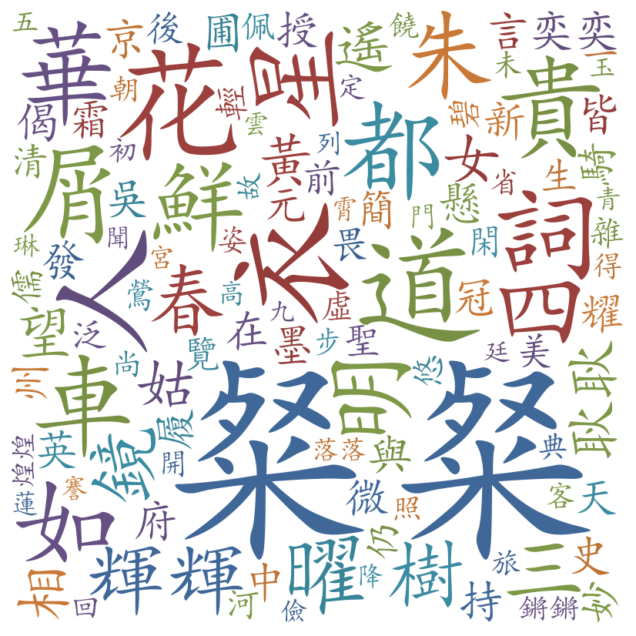

Counter({'粲粲': 17, '人': 3, '衣': 3, '道': 3, '花': 3, '車': 2, '都': 2, '詞': 2, '如': 2, '貴': 2, '星': 2, '華': 2, '屑': 2, '朱': 2, '鮮': 2, '明': 2, '四': 2, '曜': 2, '輝輝': 2, '樹': 2, '鏡': 2, '三': 2, '春': 2, '黃': 1, '姑': 1, '女': 1, '耿耿': 1, '遙': 1, '相': 1, '望': 1, '奕奕': 1, '騎': 1, '在': 1, '持': 1, '簡': 1, '墨': 1, '皆': 1, '英': 1, '微': 1, '言': 1, '發': 1, '新': 1, '偈': 1, '懸': 1, '圃': 1, '吳': 1, '與': 1, '史': 1, '冠': 1, '耀': 1, '天': 1, '京': 1, '府': 1, '中': 1, '妙': 1, '授': 1, '履': 1, '霜': 1, '元': 1, '州': 1, '前': 1, '聖': 1, '畏': 1, '後': 1, '生': 1, '美': 1, '仍': 1, '清': 1, '閑': 1, '一': 1, '儒': 1, '泛': 1, '覽': 1, '輕': 1, '河': 1, '悠': 1, '碧': 1, '虛': 1, '鶯': 1, '雜': 1, '佩': 1, '鏘鏘': 1, '饒': 1, '省': 1, '步': 1, '旅': 1, '客': 1, '姿': 1, '定': 1, '門': 1, '尚': 1, '未': 1, '開': 1, '初': 1, '照': 1, '回': 1, '故': 1, '得': 1, '朝': 1, '典': 1, '落落': 1, '廷': 1, '謇': 1, '儉': 1, '蓮': 1, '高': 1, '九': 1, '霄': 1, '聞': 1, '降': 1, '五': 1, '雲': 1, '煌煌': 1, '青': 1, '琳': 1, '宮': 1, '列': 1, '玉': 1})


In [43]:
wordcloud('奕奕')

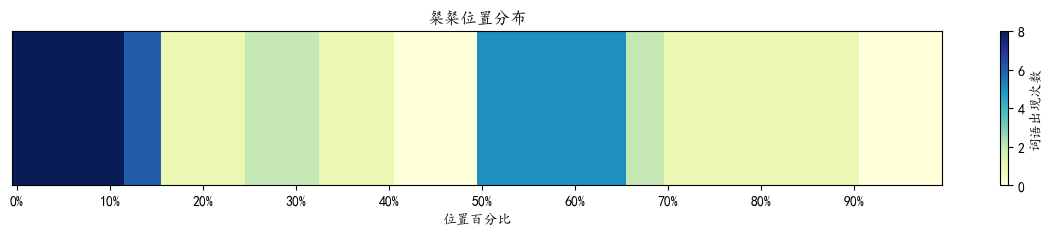

In [44]:
li_position(['奕奕'])

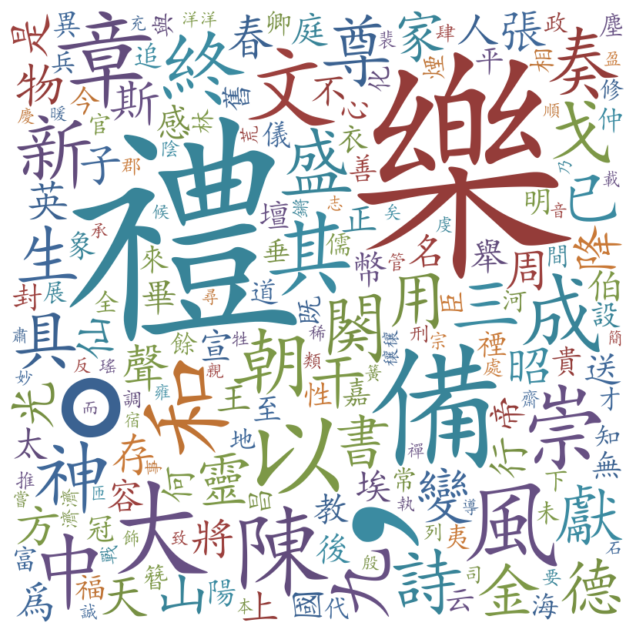

Counter({'禮': 356, '樂': 356, '，': 354, '。': 354, '備': 58, '大': 34, '以': 32, '章': 28, '和': 28, '風': 28, '文': 26, '陳': 26, '崇': 22, '其': 22, '終': 20, '成': 20, '中': 18, '新': 18, '朝': 16, '神': 16, '奏': 16, '闋': 16, '九': 16, '盛': 16, '尊': 16, '戈': 16, '詩': 16, '具': 14, '獻': 14, '用': 14, '三': 14, '生': 14, '金': 12, '德': 12, '已': 12, '變': 12, '靈': 12, '干': 12, '書': 12, '家': 12, '山': 12, '物': 10, '聲': 10, '天': 10, '降': 10, '斯': 10, '光': 10, '春': 10, '張': 10, '昭': 10, '方': 10, '周': 10, '是': 10, '存': 10, '仙': 10, '子': 10, '行': 10, '將': 10, '英': 10, '爲': 10, '人': 10, '埃': 8, '感': 8, '不': 8, '帝': 8, '舉': 8, '幣': 8, '畢': 8, '容': 8, '庭': 8, '宣': 8, '名': 8, '伯': 8, '何': 8, '送': 8, '太': 8, '上': 8, '王': 8, '國': 8, '正': 8, '後': 8, '教': 8, '陽': 6, '象': 6, '心': 6, '今': 6, '舊': 6, '貴': 6, '明': 6, '無': 6, '衣': 6, '冠': 6, '壇': 6, '至': 6, '禋': 6, '福': 6, '云': 6, '平': 6, '性': 6, '嘉': 6, '既': 6, '設': 6, '封': 6, '來': 6, '儀': 6, '垂': 6, '善': 6, '追': 6, '異': 6, '臣': 6, '海': 6, '道': 6, '仲': 6, '夷': 6, '化': 6, '昌': 6

In [25]:


# 统计每一个词的共现词有哪些，以列表存储
wordlist = ["禮","樂"]
wordslines = []
for word in wordlist:
    for line in tokenized_corpus:
        jiaoji = len(set(line) & set(wordlist))
        if jiaoji == len(wordlist):
            wordslines = wordslines + line
            
# 统计每个重言词的共现词的频次
from collections import Counter
wordslines_counter = Counter(wordslines)

font_path = r'C:\Windows\Fonts\simkai.ttf'
# 自定义颜色函数
def custom_color_func(word, font_size, position, orientation, random_state, **kwargs):
    color_list = ['#3b6291', '#943c39', '#779043', '#624c7c','#388498', '#bf7334', '#3f6899', '#9c403d', '#7d9847', '#675083', '#3b8ba1', '#c97937']
    random_color = random.choice(color_list)

    return random_color  # 自定义16进制颜色码


# 创建词云对象
wordcloud = WordCloud(width=800, height=800,font_path=font_path, background_color='white',color_func=custom_color_func).generate_from_frequencies(wordslines_counter)

# 绘制词云
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 关闭坐标轴
plt.show()
print(wordslines_counter)